In [7]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID as model
reload(model)
import sys
sys.path.append('Sequence_dependent_model')
import preprocessing

times = [0.0,12.0,60.0,180.0,600.0,1800.0,6000.0,18000.0,60000.0]
guide = 20

path_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
filename_data = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'

### Errorbars, weighted average kclv

In [8]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data)
_, ydatawa, yerrwa = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,False,False)
#_, ydatamedian, yerrmedian = processing.prepare_multiprocessing_nucleaseq(filename, path_to_data, True)
_, ydatalog, yerrlog = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,True,False)
_, ydatalogfull, _ = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,False,False,True,False)


filename_daba = 'cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-20.csv'
path_to_data_daba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

filename_aba = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv'
path_to_data_aba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

_, ydata_daba, yerr_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,False)
_, ydatawa_daba, yerrwa_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,True)

_, ydata_aba, yerr_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,False)
_, ydatawa_aba, yerrwa_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,True)

datacompclv = []
datacompon = []
datacompdaba = []
datacompaba = []
pos = []
kclv = []
kon = []
daba = []
aba = []
errorclv = []
erroron = []
errordaba = []
erroraba = []

i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            pos.append(xdata[a][0])
            kclv.append(ydatawa[a][0][0])
            kon.append(ydatawa[a][1][0])
            daba.append(ydatawa_daba[a][1][0])
            aba.append(ydatawa_aba[a][1][0])
            errorclv.append(yerrwa[a][0][0])
            datacompclv.append(ydata[a][0])
            datacompon.append(ydata[a][1])
            datacompdaba.append(ydata_daba[a][1])
            datacompaba.append(ydata_aba[a][1])
            erroron.append(yerrwa[a][1][0])
            errordaba.append(yerrwa_daba[a][1][0])
            erroraba.append(yerrwa_aba[a][1][0])
            
            i = i + 1
    
pos.append(21)
kclv.append(ydatawa[0][0][0])
kon.append(ydatawa[0][1][0])
daba.append(0.0)
aba.append(ydatawa_aba[0][1][0])
errorclv.append(yerrwa[0][0][0])
erroron.append(yerrwa[0][1][0])
errordaba.append(0.0)
erroraba.append(yerrwa_aba[0][1][0])
datacompclv.append(ydata[0][0])
datacompon.append(ydata[0][1])
datacompdaba.append([])
datacompaba.append(ydata_aba[0][1])


pos = np.array(pos)
kclv = np.array(kclv)
kon = np.array(kon)
daba = np.array(daba)
aba = np.array(aba)
errorclv = np.array(errorclv)
erroron = np.array(erroron)
errordaba = np.array(errordaba)
erroraba = np.array(erroraba)

In [9]:
k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
daba_double = np.zeros([20,20])
aba_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydatalog[a][0][0])
        #if ydatalog[a][0][0] < -5:
        #    k_double[j-1,i-1] = np.nan
        if len(ydatalog[a][1])==0:
            on_double[j-1,i-1] = np.nan
        else:
            on_double[j-1,i-1] = ydatalog[a][1][0]
        daba_double[j-1,i-1] = ydatawa_daba[a][1][0]
        aba_double[j-1,i-1] = ydatawa_aba[a][1][0]
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1,21))
on_double_df = pd.DataFrame(on_double, index=range(1,21), columns=range(1,21))
daba_double_df = pd.DataFrame(daba_double, index=range(1,21), columns=range(1,21))
aba_double_df = pd.DataFrame(aba_double, index=range(1,21), columns=range(1,21))

### Show result of fit

PAM: 0.9996488627246625
From solution: 4.539511348580499
Internal: 2.9756342366400004
Cleavage: 3.97675783241


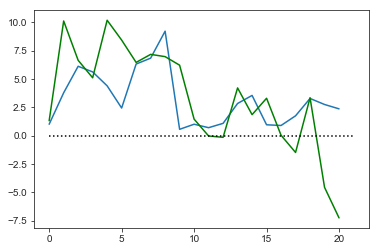

In [16]:
#model_ID = 'Clv_Saturated_general_energies_landscape+general_energies_no_kPR_fixed_PAM_landscape'; parnum = '43'
#model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat+On_edit_boyle_landscape_flat'; parnum = '25'
#model_ID = 'Clv_Saturated_edit_boyle_landscape+On_edit_boyle_landscape'; parnum = '35'
#model_ID = 'Clv_Saturated_general_energies_landscape+general_energies_no_kPR_landscape'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat_constant_ei+On_edit_boyle_landscape_flat_constant_ei'; parnum = '7'
#model_ID = 'First_bump_fixed_for_engineered_cas+First_bump_fixed_for_engineered_cas_on'; parnum = '25'
#model_ID = 'First_bump_fixed_for_engineered_cas_fixed_ei+First_bump_fixed_for_engineered_cas_on_fixed_ei'; parnum = '13'
#model_ID = 'Engineered_cas_fixed_ei+Engineered_cas_on_fixed_ei'; parnum = '21'
#model_ID = 'Engineered_cas_constant_ei+Engineered_cas_on_constant_ei'; parnum = '21'
model_ID = 'Clv_init_limit_Saturated_general_energies_fixed_koff+Bnd_init_limit_general_energies_fixed_koff'; parnum = '44'

filename = 'fit_28_10_2019_sim_9.txt'
path = '../fits_Stijn/28_10_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)
#final_par_np = np.append(final_par_np[0:33],np.append([-2.4],final_par_np[33:35]))
#final_par_np = np.append([2.7],np.append(final_par_np[0:40],np.append([-2.5],final_par_np[40:42])))

#final_par_np[-1] = 2.

#final_par_np = np.load('median-parameters.npy')
#final_par_np[8] += 3.
#final_par_np[9] -= 3.

#final_par_np[21:41] = 6.9
final_par_np_on = final_par_np.copy()

## aba -> on
if True:
    c = 4.534
    final_par_np_on[0] = final_par_np_on[0] - np.log(c)
    final_par_np_on[-3] = final_par_np_on[-3] + np.log10(c)

## on -> aba
if False:
    c = 4.553
    final_par_np[0] = final_par_np[0] + np.log(c)
    final_par_np[-3] = final_par_np[-3] - np.log10(c)

#print final_par_np


#When not all 44 parameters are present
#all_par = np.zeros(44)
#all_par[0] = 1.4 #PAM
#all_par[1:21] = final_par_np[0:20] #eC
#all_par[21:41] = final_par_np[20:40] #eI
#all_par[41] = -2.3 #rate from solution
#all_par[42] = final_par_np[40] #internal rate
#all_par[43] = final_par_np[41] #cleavage rate
#final_par_np = all_par

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np_on,model_ID)
model_ID_clv,model_ID_on,parameters_clv,parameters_aba = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
#print energies
#print rates

best_fit_boyle = np.loadtxt('best_fit_new.txt')
best_fit_boyle = -np.cumsum(best_fit_boyle[0:21])

plt.plot(range(0,21), -np.cumsum(np.append(-energies[0],energies[1:21])))
plt.plot(range(0,21),best_fit_boyle,'g')
plt.plot([0,21],[0,0],'k:')

print 'PAM: ' + str(energies[0])
print 'From solution: ' + str(parameters_on[-2])
print 'Internal: ' + str(parameters_on[-1])
print 'Cleavage: ' + str(parameters_clv[-1])

## Single mismatches

OT-ABA: 2.5505365107173428


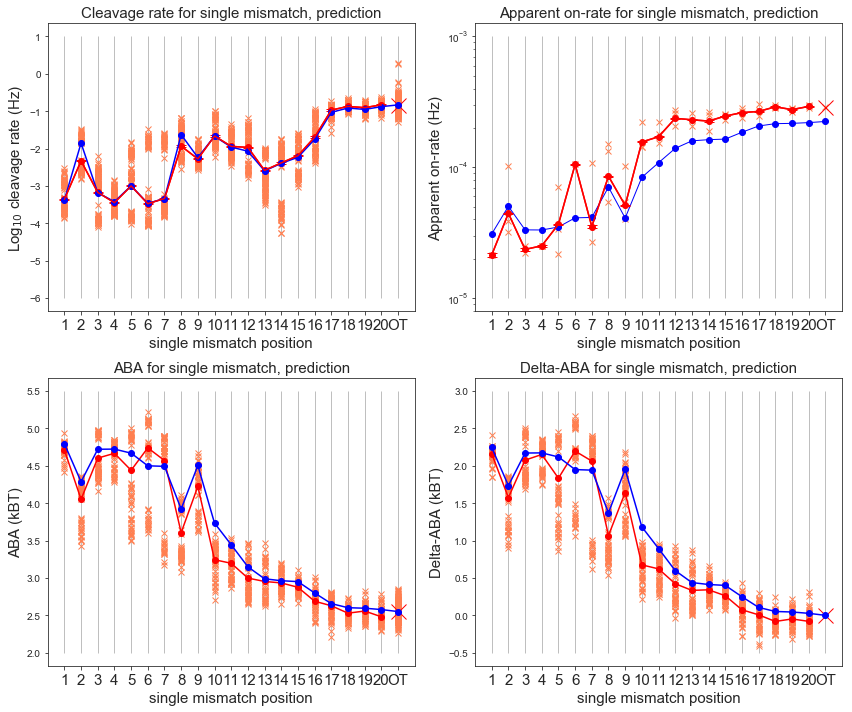

In [17]:
legend = False

f,ax = plt.subplots(2,2,sharey=False,figsize=[12,10])

k = np.zeros(21)
on = np.zeros(21)
dabafit = np.zeros(21)
abafit = np.zeros(21)

#conc = np.array([1.,30.,100.])
conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])

ref = 10. # in nanomolair
otaba = clv.calc_ABA(parameters_aba,conc,ref,[],model_ID_on)
print 'OT-ABA: ' + str(otaba)

for i in range(1,guide+1):
    mismatch = [i]
    k[i-1],on[i-1] = clv.calc_clv_on(final_par_np_on,model_ID,mismatch,guide)
    _,dabafit[i-1] = clv.calc_clv_daba(final_par_np,model_ID,mismatch,guide,conc,ref,otaba)
    _,abafit[i-1] = clv.calc_clv_aba(final_par_np,model_ID,mismatch,guide,conc,ref)
    
k[-1],on[-1] = clv.calc_clv_on(final_par_np_on,model_ID,[],guide)
abafit[-1] = 0.
abafit[-1] = otaba

for i in range(21):
    #print len(datacompclv[i])
    plot1 = ax[0][0].plot((i+1)*np.ones(len(datacompclv[i])),datacompclv[i],marker='x',color='coral',linewidth=0,label='Experimental data')
plot2 = ax[0][0].plot(range(1,21),kclv[0:20],marker='o',color='r',label='Weighted average\n(mutants)')
ax[0][0].errorbar(range(1,21),kclv[0:20],yerr=errorclv[0:20],color='r',capsize=5)
plot3 = ax[0][0].plot(21,kclv[20],marker='x',color='r',markersize=15,label='Weighted average\n(on-target)')
plot4 = ax[0][0].plot(range(1,22),np.log10(k),color='b',marker='o',label='Prediction')
if legend:
    ax[0][0].legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
ax[0][0].set_xlabel('single mismatch position', fontsize=15)
ax[0][0].set_ylabel('Log$_{10}$ cleavage rate (Hz)', fontsize=15)
ax[0][0].set_title('Cleavage rate for single mismatch, prediction', fontsize=15)
ax[0][0].set_xticks(range(1,22));
ax[0][0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
ax[0][0].vlines(range(1,22),-6,1,color='grey',linewidth=0.5);
#plt.axis([0,22,-7,0]);

for i in range(21):
    plot1 = ax[0][1].plot((i+1)*np.ones(len(datacompon[i])),datacompon[i],marker='x',color='coral',linewidth=0,label='Experimental data')
plot2 = ax[0][1].plot(range(1,21),kon[0:20],marker='o',color='r',label='Weighted average')
plot3 = ax[0][1].plot(21,kon[20],marker='x',color='r',markersize=15,label='On-target')
plot4 = ax[0][1].semilogy(range(1,22),on,marker='o',linewidth=1,color='blue',label='Prediction')
ax[0][1].errorbar(range(1,21),kon[0:20],yerr=erroron[0:20],color='r',capsize=5)
#for i in range(21):
    #if i+1==1 or i+1==3 or i+1==4:
    #    plt.plot(i+1,kon[i],marker='X',color='grey',markersize=10)
    #if i+1==6 or i+1==7:
    #    ax[0][1].plot(i+1,kon[i],marker='X',color='k',markersize=10)
if legend:
    ax[0][1].legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
ax[0][1].set_xlabel('single mismatch position', fontsize=15)
ax[0][1].set_ylabel('Apparent on-rate (Hz)', fontsize=15)
ax[0][1].set_title('Apparent on-rate for single mismatch, prediction', fontsize=15)
ax[0][1].set_xticks(range(1,22));
ax[0][1].set_xticklabels(range(1,21)+['OT'],fontsize=15)
ax[0][1].vlines(range(1,22),10**-5.,10**-3.,color='grey',linewidth=0.5);
#ax[0][1].axis([0,22,10**-1.5,10**0])

for i in range(20):
    plot1, = ax[1][1].plot((i+1)*np.ones(len(datacompdaba[i])),datacompdaba[i],marker='x',color='coral',linewidth=0,label='Experimental \ndata')
plot2, = ax[1][1].plot(range(1,21),daba[:-1],marker='o',color='r',label='Weighted \naverage')
plot3, = ax[1][1].plot(21,daba[-1],marker='x',color='r',markersize=15,label='On-target')
plot4, = ax[1][1].plot(range(1,22),dabafit,marker='o',color='b',label='Prediction')
if legend:
    ax[1][1].legend(handles=[plot1,plot2,plot3,plot4],fontsize=15,loc='center left',bbox_to_anchor=(1,0.5))
ax[1][1].set_xlabel('single mismatch position', fontsize=15)
ax[1][1].set_ylabel('Delta-ABA (kBT)', fontsize=15)
ax[1][1].set_title('Delta-ABA for single mismatch, prediction', fontsize=15)
ax[1][1].set_xticks(range(1,22));
ax[1][1].set_xticklabels(range(1,21)+['OT'],fontsize=15)
ax[1][1].vlines(range(1,22),-0.5,3.,color='grey',linewidth=0.5);

for i in range(21):
    plot1, = ax[1][0].plot((i+1)*np.ones(len(datacompaba[i])),datacompaba[i],marker='x',color='coral',linewidth=0,label='Experimental \ndata')
plot2, = ax[1][0].plot(range(1,21),aba[:-1],marker='o',color='r',label='Weighted \naverage')
plot3, = ax[1][0].plot(21,aba[-1],marker='x',color='r',markersize=15,label='On-target')
plot4, = ax[1][0].plot(range(1,22),abafit,marker='o',color='b',label='Prediction')
if legend:
    ax[1][0].legend(handles=[plot1,plot2,plot3,plot4],fontsize=15,loc='center left',bbox_to_anchor=(1,0.5))
ax[1][0].set_xlabel('single mismatch position', fontsize=15)
ax[1][0].set_ylabel('ABA (kBT)', fontsize=15)
ax[1][0].set_title('ABA for single mismatch, prediction', fontsize=15)
ax[1][0].set_xticks(range(1,22));
ax[1][0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
ax[1][0].vlines(range(1,22),2.,5.5,color='grey',linewidth=0.5);

plt.tight_layout()

## Double mismatches

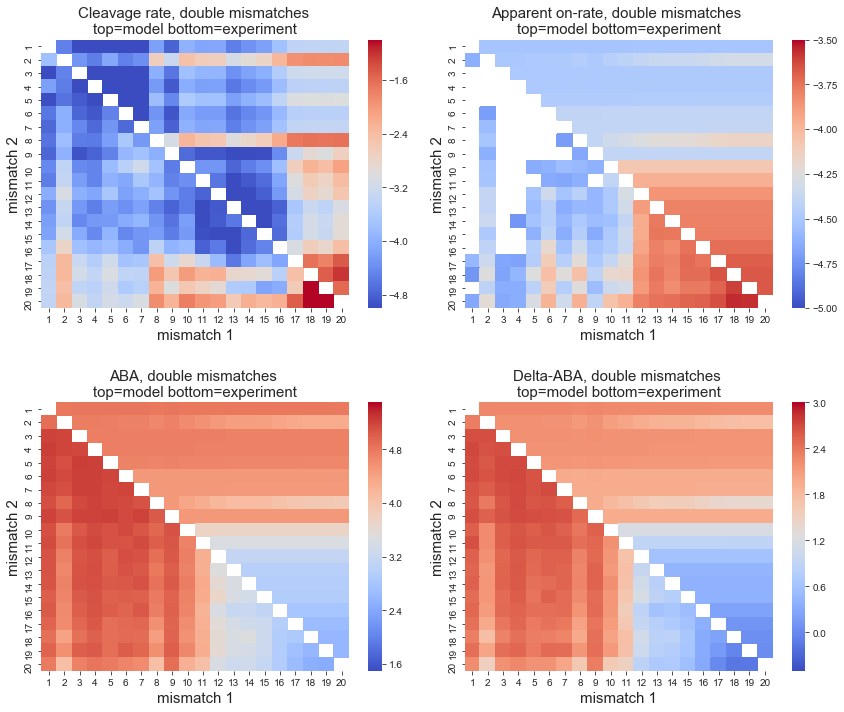

In [18]:
f,ax = plt.subplots(2,2,sharey=False,figsize=[12,10])

k_matrix = np.zeros([20,20])
on_matrix = np.zeros([20,20])
daba_matrix = np.zeros([20,20])
aba_matrix = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix[i-1,j-1], on_matrix[i-1,j-1] = np.log10(clv.calc_clv_on(final_par_np_on,model_ID,mismatch_positions,guide))
        _, daba_matrix[i-1,j-1] = clv.calc_clv_daba(final_par_np,model_ID,mismatch_positions,guide,conc,ref,otaba)
        _, aba_matrix[i-1,j-1] = clv.calc_clv_aba(final_par_np,model_ID,mismatch_positions,guide,conc,ref)
        
        
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))
on_df = pd.DataFrame(on_matrix, index=range(1,21), columns=range(1,21))
daba_df = pd.DataFrame(daba_matrix, index=range(1,21), columns=range(1,21))
aba_df = pd.DataFrame(aba_matrix, index=range(1,21), columns=range(1,21))

combined_df_wa = k_df + k_double_df
combined_on = on_df + on_double_df
combined_daba = daba_df + daba_double_df
combined_aba = aba_df + aba_double_df

for i in range(1,21):
    combined_df_wa[i].loc[i]= np.nan
    combined_on[i].loc[i] = np.nan
    combined_daba[i].loc[i] = np.nan
    combined_aba[i].loc[i] = np.nan

sns.heatmap(combined_df_wa, cmap='coolwarm', cbar=True,ax=ax[0][0], vmin=-5, vmax = -1)
ax[0][0].set_xlabel('mismatch 1', fontsize=15)
ax[0][0].set_ylabel('mismatch 2', fontsize=15)
ax[0][0].set_title('Cleavage rate, double mismatches \ntop=model bottom=experiment', fontsize=15)

sns.heatmap(combined_on,cmap='coolwarm', cbar=True,ax=ax[0][1], vmin = -5, vmax = -3.5)
ax[0][1].set_xlabel('mismatch 1', fontsize=15)
ax[0][1].set_ylabel('mismatch 2', fontsize=15)
ax[0][1].set_title('Apparent on-rate, double mismatches \ntop=model bottom=experiment', fontsize=15)

sns.heatmap(combined_daba,cmap='coolwarm', cbar=True,ax=ax[1][1], vmin = -0.5, vmax = 3.)
ax[1][1].set_xlabel('mismatch 1', fontsize=15)
ax[1][1].set_ylabel('mismatch 2', fontsize=15)
ax[1][1].set_title('\nDelta-ABA, double mismatches \ntop=model bottom=experiment', fontsize=15)

sns.heatmap(combined_aba,cmap='coolwarm', cbar=True,ax=ax[1][0], vmin = 1.5, vmax = 5.5)
ax[1][0].set_xlabel('mismatch 1', fontsize=15)
ax[1][0].set_ylabel('mismatch 2', fontsize=15)
ax[1][0].set_title('\nABA, double mismatches \ntop=model bottom=experiment', fontsize=15)

plt.tight_layout()

## Correlations

0.8668060830705444
0.800834156959948
0.9413836241183235
0.9637182618586885
0.9493699963875727
0.9355032259989193


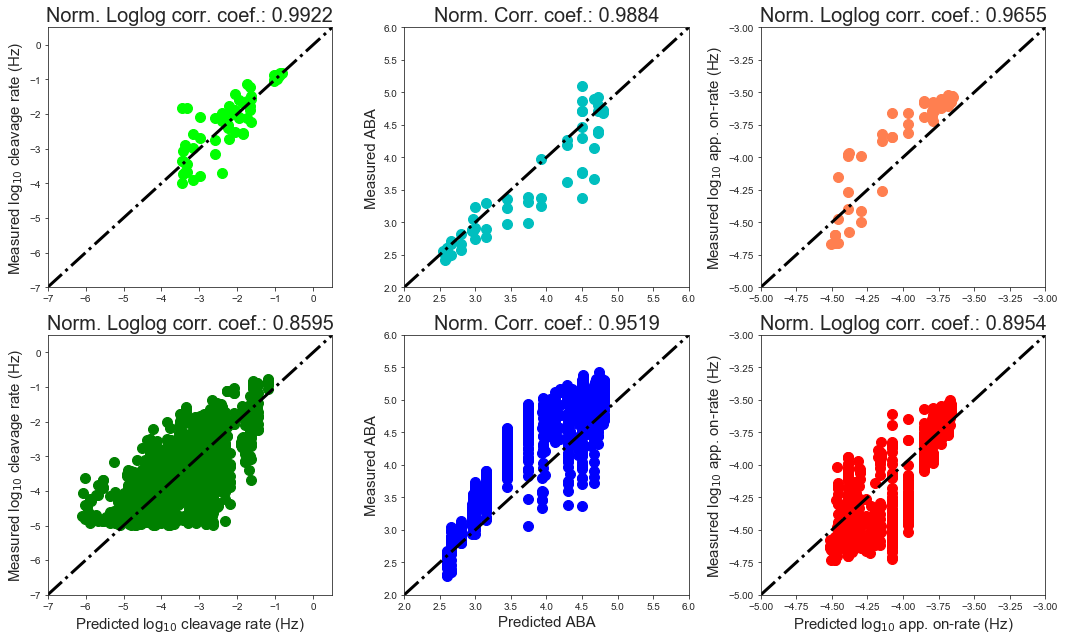

In [19]:
path = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata_all,ydata_all_wa,yerr_all_wa = preprocessing.prepare_multiprocessing_seq_dep_wa('WT_cleavage_rate_and_y0_Canonical_OT-r_0-2_target.csv',path)

path = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
file2 = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2_target.csv'
xdata_all_aba,ydata_all_wa_aba,yerr_all_wa_aba = preprocessing.prepare_multiprocessing_seq_dep_wa_aba(file2,path)


smm_data_clv = []
dmm_data_clv = []
smm_fit_clv = []
dmm_fit_clv = []
smm_ref_clv = []
dmm_ref_clv = []

smm_data_aba = []
dmm_data_aba = []
smm_fit_aba = []
dmm_fit_aba = []
smm_ref_aba = []
dmm_ref_aba = []

smm_data_on = []
dmm_data_on = []
smm_fit_on = []
dmm_fit_on = []
smm_ref_on = []
dmm_ref_on = []

for i in range(len(xdata_all)):
    if len(xdata_all[i][2])<2:
        clv_temp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,xdata_all[i][2],20))
        for j in range(len(ydata_all_wa[i])):
            if  ydata_all_wa[i][j]>-5 and ydata_all_wa[i][j]<0:
                smm_data_clv.append(ydata_all_wa[i][j])
                smm_fit_clv.append(clv_temp)
                if len(xdata_all[i][2])>0:
                    smm_ref_clv.append(kclv[xdata_all[i][2][0]-1])
                else:
                    smm_ref_clv.append(kclv[-1])
    if len(xdata_all[i][2])==2:
        clv_temp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,xdata_all[i][2],20))
        for j in range(len(ydata_all_wa[i])):
            if  ydata_all_wa[i][j]>-5 and ydata_all_wa[i][j]<0:
                dmm_data_clv.append(ydata_all_wa[i][j])
                dmm_fit_clv.append(clv_temp)
                dmm_ref_clv.append(k_double[xdata_all[i][2][1]-1,xdata_all[i][2][0]-1])
                
smm_corr_ref_clv = np.corrcoef([smm_data_clv,smm_ref_clv])[0][1]
dmm_corr_ref_clv = np.corrcoef([dmm_data_clv,dmm_ref_clv])[0][1]
print smm_corr_ref_clv
print dmm_corr_ref_clv
                
                
for i in range(len(xdata_all_aba)):
    if len(xdata_all_aba[i][2])<2:
        aba_temp = clv.calc_ABA(parameters_aba,conc,ref,xdata_all_aba[i][2],model_ID_on)
        for j in range(len(ydata_all_wa_aba[i])):
            smm_data_aba.append(ydata_all_wa_aba[i][j])
            smm_fit_aba.append(aba_temp)
            if len(xdata_all_aba[i][2])>0:
                smm_ref_aba.append(aba[xdata_all_aba[i][2][0]-1])
            else:
                smm_ref_aba.append(aba[-1])
    if len(xdata_all_aba[i][2])==2:
        aba_temp = clv.calc_ABA(parameters_aba,conc,ref,xdata_all_aba[i][2],model_ID_on)
        for j in range(len(ydata_all_wa_aba[i])):
            dmm_data_aba.append(ydata_all_wa_aba[i][j])
            dmm_fit_aba.append(aba_temp)
            dmm_ref_aba.append(aba_double[xdata_all_aba[i][2][1]-1,xdata_all_aba[i][2][0]-1])
            
smm_corr_ref_aba = np.corrcoef([smm_data_aba,smm_ref_aba])[0][1]
dmm_corr_ref_aba = np.corrcoef([dmm_data_aba,dmm_ref_aba])[0][1]
print smm_corr_ref_aba
print dmm_corr_ref_aba
            
for i in range(len(xdata)):
    if len(xdata[i])<2:
        _,on_temp = clv.calc_clv_on(final_par_np_on,model_ID,xdata[i],20)
        on_temp = np.log10(on_temp)
        for j in range(len(ydatalogfull[i][1])):
            smm_data_on.append(ydatalogfull[i][1][j])
            smm_fit_on.append(on_temp)
            if len(xdata[i])>0:
                smm_ref_on.append(np.log10(kon[xdata[i][0]-1]))
            else:
                smm_ref_on.append(np.log10(kon[-1]))
    if len(xdata[i])==2:
        _,on_temp = clv.calc_clv_on(final_par_np_on,model_ID,xdata[i],20)
        on_temp = np.log10(on_temp)
        for j in range(len(ydatalogfull[i][1])):
            dmm_data_on.append(ydatalogfull[i][1][j])
            dmm_fit_on.append(on_temp)
            dmm_ref_on.append(on_double[xdata[i][1]-1,xdata[i][0]-1])
            
smm_corr_ref_on = np.corrcoef([smm_data_on,smm_ref_on])[0][1]
dmm_corr_ref_on = np.corrcoef([dmm_data_on,dmm_ref_on])[0][1]
print smm_corr_ref_on
print dmm_corr_ref_on

f,ax = plt.subplots(2,3,sharey=False,figsize=[15,9])
plt1, = ax[0][0].plot(smm_fit_clv,smm_data_clv,marker='o',markersize=10,color='lime',linewidth=0.0, label='smm')
plt2, = ax[1][0].plot(dmm_fit_clv,dmm_data_clv,marker='o',markersize=10,color='green',linewidth=0.0, label='dmm')
ax[0][0].plot([-7,0.5],[-7,0.5],'k-.',linewidth=3)
ax[0][0].axis([-7,0.5,-7,0.5])
ax[1][0].plot([-7,0.5],[-7,0.5],'k-.',linewidth=3)
ax[1][0].axis([-7,0.5,-7,0.5])
ax[0][0].set_title('Norm. Loglog corr. coef.: ' + str(np.round(np.corrcoef([smm_data_clv,smm_fit_clv])[0][1]/smm_corr_ref_clv,4)), fontsize=20)
ax[1][0].set_title('Norm. Loglog corr. coef.: '+ str(np.round(np.corrcoef([dmm_data_clv,dmm_fit_clv])[0][1]/dmm_corr_ref_clv,4)), fontsize=20)
ax[1][0].set_xlabel('Predicted log$_{10}$ cleavage rate (Hz)',fontsize=15)
ax[1][0].set_ylabel('Measured log$_{10}$ cleavage rate (Hz)',fontsize=15)
ax[0][0].set_ylabel('Measured log$_{10}$ cleavage rate (Hz)',fontsize=15)

plt1, = ax[0][1].plot(smm_fit_aba,smm_data_aba,marker='o',markersize=10,color='c',linewidth=0.0, label='smm')
plt2, = ax[1][1].plot(dmm_fit_aba,dmm_data_aba,marker='o',markersize=10,color='b',linewidth=0.0, label='dmm')
ax[0][1].plot([2.,6.],[2.,6.],'k-.',linewidth=3)
ax[0][1].axis([2.,6.,2.,6.])
ax[1][1].plot([2.,6.],[2.,6.],'k-.',linewidth=3)
ax[1][1].axis([2.,6.,2.,6.])
ax[0][1].set_title('Norm. Corr. coef.: ' + str(np.round(np.corrcoef([smm_data_aba,smm_fit_aba])[0][1]/smm_corr_ref_aba,4)), fontsize=20)
ax[1][1].set_title('Norm. Corr. coef.: '+ str(np.round(np.corrcoef([dmm_data_aba,dmm_fit_aba])[0][1]/dmm_corr_ref_aba,4)), fontsize=20)
ax[1][1].set_xlabel('Predicted ABA',fontsize=15)
ax[1][1].set_ylabel('Measured ABA',fontsize=15)
ax[0][1].set_ylabel('Measured ABA',fontsize=15)

plt1, = ax[0][2].plot(smm_fit_on,smm_data_on,marker='o',markersize=10,color='coral',linewidth=0.0, label='smm')
plt2, = ax[1][2].plot(dmm_fit_on,dmm_data_on,marker='o',markersize=10,color='red',linewidth=0.0, label='dmm')
ax[0][2].plot([-5.,-3.],[-5.,-3.],'k-.',linewidth=3)
ax[0][2].axis([-5.,-3.,-5.,-3.])
ax[1][2].plot([-5.,-3.],[-5.,-3.],'k-.',linewidth=3)
ax[1][2].axis([-5.,-3.,-5.,-3.])
ax[0][2].set_title('Norm. Loglog corr. coef.: ' + str(np.round(np.corrcoef([smm_data_on,smm_fit_on])[0][1]/smm_corr_ref_on,4)), fontsize=20)
ax[1][2].set_title('Norm. Loglog corr. coef.: '+ str(np.round(np.corrcoef([dmm_data_on,dmm_fit_on])[0][1]/dmm_corr_ref_on,4)), fontsize=20)
ax[1][2].set_xlabel('Predicted log$_{10}$ app. on-rate (Hz)',fontsize=15)
ax[1][2].set_ylabel('Measured log$_{10}$ app. on-rate (Hz)',fontsize=15)
ax[0][2].set_ylabel('Measured log$_{10}$ app. on-rate (Hz)',fontsize=15)


#plt.legend(handles=[plt1,plt2],fontsize=17)
plt.tight_layout()

## Chi squared evolution

241.930865536


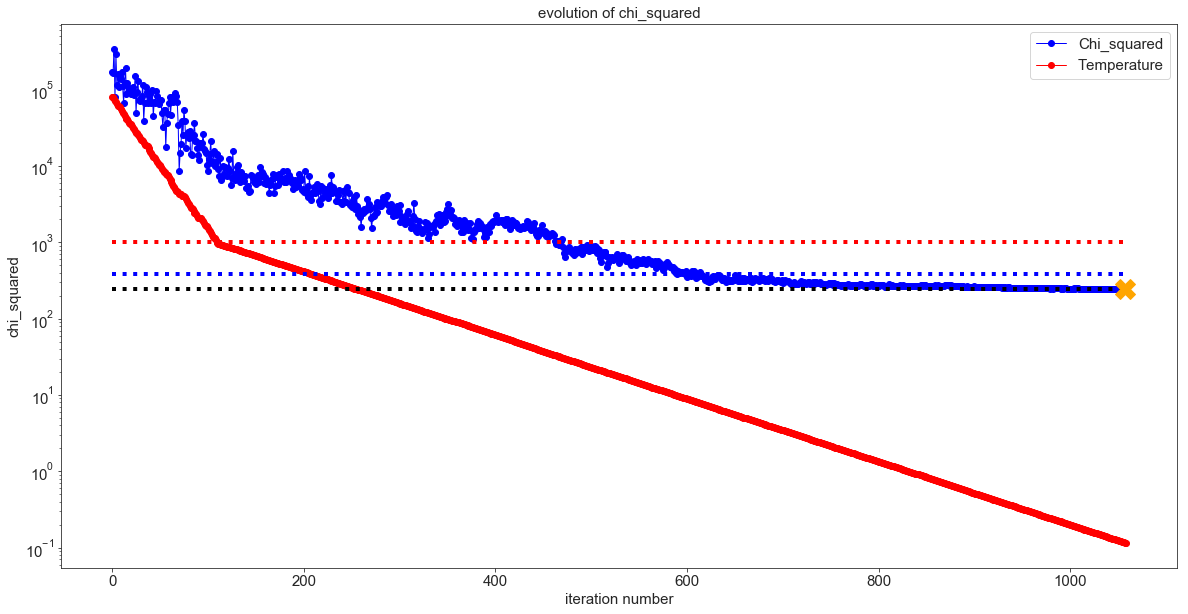

In [9]:
plt.figure(figsize=[20,10])
plt.plot(chi, marker='o', linewidth=1, color='blue')
plt.xlabel('iteration number', fontsize=15)
plt.ylabel('chi_squared', fontsize=15)
plt.title('evolution of chi_squared', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(T, marker='o', linewidth=1, color='red')
plt.plot([0,len(chi)],[min(chi),min(chi)],linewidth=4,linestyle=':',color='k')
plt.plot([0,len(chi)],[380,380],linewidth=4,linestyle=':',color='b')
plt.plot([0,len(chi)],[1000,1000],linewidth=4,linestyle=':',color='r')
plt.semilogy(np.argmin(chi),min(chi),marker='X',markersize=20,color='orange')
plt.legend(['Chi_squared','Temperature'],fontsize=15)
print min(chi)

## Chi calculator

In [14]:
perfectClv = np.float(len(ydatawa[0][0]))
perfectOn = np.float(len(ydatawa[0][1]))
singleClv = 0.0
singleOn = 0.0
doubleClv = 0.0
doubleOn = 0.0
for i in range(len(xdata)):
    if len(xdata[i])==1:
        #if xdata[i][0]==1 or xdata[i][0]==3 or xdata[i][0]==4 or xdata[i][0]==6 or xdata[i][0]==7:
        if xdata[i][0]==6 or xdata[i][0]==7:
            ydatawa[i][1] = []
            yerrwa[i][1] = []
            ydatalog[i][1] = []
            yerrlog[i][1] = []
        singleClv += len(ydatawa[i][0])
        singleOn += len(ydatawa[i][1])
    if len(xdata[i])==2:
        doubleClv += len(ydatawa[i][0])
        doubleOn += len(ydatawa[i][1])

chi_weights = [1/perfectClv,1/singleClv,1/doubleClv,1/perfectOn,1/singleOn,1/doubleOn]

chi = 0.
for i in range(len(xdata)):
    chi += clv.calc_chi_squared(final_par_np_on,xdata[i],ydatawa[i],yerrwa[i],chi_weights,True,False,False,20,model_ID)
    
print 'normal on-rate: ' + str(np.round(chi))

chi = 0.
for i in range(len(xdata)):
        chi += clv.calc_chi_squared(final_par_np_on,xdata[i],ydatalog[i],yerrlog[i],chi_weights,True,True,False,20,model_ID)
    
print 'log on-rate: ' + str(np.round(chi))

normal on-rate: 1041.0
log on-rate: 266.0


## Calculate c factor from ABA to Boyle

In [26]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat+On_edit_boyle_landscape_flat'; parnum = '25'
#model_ID = 'Clv_Saturated_edit_boyle_landscape+On_edit_boyle_landscape'; parnum = '35'
#model_ID = 'Clv_Saturated_general_energies_landscape+general_energies_no_kPR_landscape'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat_constant_ei+On_edit_boyle_landscape_flat_constant_ei'; parnum = '7'
#model_ID = 'First_bump_fixed_for_engineered_cas+First_bump_fixed_for_engineered_cas_on'; parnum = '25'
#model_ID = 'First_bump_fixed_for_engineered_cas_fixed_ei+First_bump_fixed_for_engineered_cas_on_fixed_ei'; parnum = '13'
#model_ID = 'Engineered_cas_fixed_ei+Engineered_cas_on_fixed_ei'; parnum = '21'
#model_ID = 'Engineered_cas_constant_ei+Engineered_cas_on_constant_ei'; parnum = '21'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)


parameters = final_par_np.copy()
c = (np.linspace(4.,5.,100))

chi = []
chi_weights = [0.,0.,0.,1.,1./20.,1./190.]

for i in c:
    parameters[0] = final_par_np[0] - np.log(i)
    parameters[-3] = final_par_np[-3] + np.log10(i)
    #print parameters[0], parameters[-3]
    
    chitemp = 0.
    for j in range(1):#range(len(xdata)):
        chitemp += clv.calc_chi_squared(parameters,xdata[j],ydatalog[j],yerrlog[j],chi_weights,True,True,False,20,model_ID)
    chi.append(chitemp)

(array([3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2]),
 <a list of 8 Text xticklabel objects>)

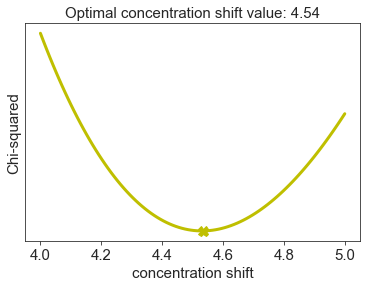

In [27]:
plt.plot(c,chi,'y',linewidth=3.)
plt.plot(c[np.argmin(chi)],chi[np.argmin(chi)],'yX',markersize=10)
#plt.vlines(np.linspace(0,10,21),0,160000,linewidth=0.5,color='grey')
plt.xlabel('concentration shift',fontsize=15)
plt.ylabel('Chi-squared',fontsize=15)
plt.title('Optimal concentration shift value: '+str(np.round(c[np.argmin(chi)],2)),fontsize=15)
plt.yticks([],[])
plt.xticks(fontsize=15)
#plt.axis([1.9,10.1,0,4000])

## Show freedom for choice of kclv

In [32]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat+On_edit_boyle_landscape_flat'; parnum = '25'
#model_ID = 'Clv_Saturated_edit_boyle_landscape+On_edit_boyle_landscape'; parnum = '35'
#model_ID = 'Clv_Saturated_general_energies_landscape+general_energies_no_kPR_landscape'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat_constant_ei+On_edit_boyle_landscape_flat_constant_ei'; parnum = '7'
#model_ID = 'First_bump_fixed_for_engineered_cas+First_bump_fixed_for_engineered_cas_on'; parnum = '25'
#model_ID = 'First_bump_fixed_for_engineered_cas_fixed_ei+First_bump_fixed_for_engineered_cas_on_fixed_ei'; parnum = '13'
#model_ID = 'Engineered_cas_fixed_ei+Engineered_cas_on_fixed_ei'; parnum = '21'
#model_ID = 'Engineered_cas_constant_ei+Engineered_cas_on_constant_ei'; parnum = '21'

filename = 'fit_18_7_2019_sim_35.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID = 'Clv_Saturated_general_energies_v2'

final_par_np = np.append(final_par_np[1:-3],final_par_np[-2:])

parameters = final_par_np.copy()
kclv = np.logspace(-1.,3.,100)

chi1 = []
chi_weights = [1.,1./20.,1./190.]

for i in kclv:
    parameters[-1] = np.log10(i)
    #print parameters[0], parameters[-3]
    
    chitemp = 0.
    for j in range(len(xdata)):
        chitemp += clv.calc_chi_squared(parameters,xdata[j],ydatalog[j][0],yerrlog[j][0],chi_weights,False,False,False,20,model_ID)
    chi1.append(chitemp)

filename = 'fit_18_7_2019_sim_24.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID = 'Clv_Saturated_general_energies_v2'

final_par_np = np.append(final_par_np[1:-3],final_par_np[-2:])

parameters = final_par_np.copy()
kclv = np.logspace(-1.,3.,100)

chi2 = []
chi_weights = [1.,1./20.,1./190.]

for i in kclv:
    parameters[-1] = np.log10(i)
    #print parameters[0], parameters[-3]
    
    chitemp = 0.
    for j in range(len(xdata)):
        chitemp += clv.calc_chi_squared(parameters,xdata[j],ydatalog[j][0],yerrlog[j][0],chi_weights,False,False,False,20,model_ID)
    chi2.append(chitemp)

7.794278336850286
7.800600742277863


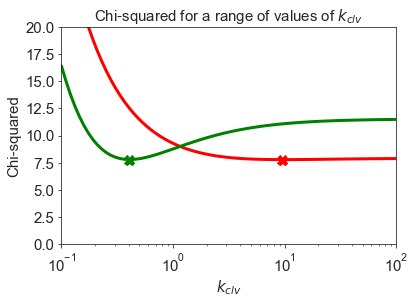

In [33]:
plot1, = plt.plot(kclv,chi1,'r',linewidth=3.)
plt.semilogx(kclv[np.argmin(chi1)],chi1[np.argmin(chi1)],'rX',markersize=10)

plot2, = plt.plot(kclv,chi2,'g',linewidth=3.)
plt.semilogx(kclv[np.argmin(chi2)],chi2[np.argmin(chi2)],'gX',markersize=10)
#plt.vlines(np.linspace(0,10,21),0,160000,linewidth=0.5,color='grey')
plt.xlabel('$k_{clv}$',fontsize=15)
plt.ylabel('Chi-squared',fontsize=15)
plt.title('Chi-squared for a range of values of $k_{clv}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.1,100.,0,20])

print chi1[np.argmin(chi1)]
print chi2[np.argmin(chi2)]

## Calculate c factor from Boyle to ABA

In [11]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat+On_edit_boyle_landscape_flat'; parnum = '25'
#model_ID = 'Clv_Saturated_edit_boyle_landscape+On_edit_boyle_landscape'; parnum = '35'
#model_ID = 'Clv_Saturated_general_energies_landscape+general_energies_no_kPR_landscape'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat_constant_ei+On_edit_boyle_landscape_flat_constant_ei'; parnum = '7'
#model_ID = 'First_bump_fixed_for_engineered_cas+First_bump_fixed_for_engineered_cas_on'; parnum = '25'
#model_ID = 'First_bump_fixed_for_engineered_cas_fixed_ei+First_bump_fixed_for_engineered_cas_on_fixed_ei'; parnum = '13'
#model_ID = 'Engineered_cas_fixed_ei+Engineered_cas_on_fixed_ei'; parnum = '21'
#model_ID = 'Engineered_cas_constant_ei+Engineered_cas_on_constant_ei'; parnum = '21'

filename = 'fit_13_6_2019_sim_40.txt'
path = '../fits_Stijn/13_6_2019/'
data = pd.read_table(path+filename,index_col=False)
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

#final_par_np = np.append([1.4],np.append(final_par_np[0:40],np.append([-2.4],final_par_np[40:42])))

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair

parameters = final_par_np.copy()
c = np.linspace(4.,5.,100)

chi = []
chi_weights = [0.,0.,0.,1.,1./20.,1./190.]

for i in c:
    parameters[0] = final_par_np[0] + np.log(i)
    parameters[-3] = final_par_np[-3] - np.log10(i)
    #print parameters[0], parameters[-3]
    
    chitemp = 0.
    for j in range(1):#range(len(xdata)):
        chitemp += clv.calc_chi_squared(parameters,xdata[j],ydatawa_aba[j],yerrwa_aba[j],chi_weights,False,False,True,20,model_ID,conc,ref)
    chi.append(chitemp)

([], <a list of 0 Text yticklabel objects>)

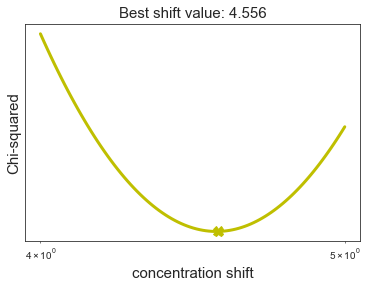

In [12]:
plt.semilogx(np.linspace(4.,5.,100),chi,'y',linewidth=3.)
plt.plot(np.linspace(4.,5.,100)[np.argmin(chi)],chi[np.argmin(chi)],'yX',markersize=10)
#plt.vlines(np.linspace(0,10,21),0,160000,linewidth=0.5,color='grey')
plt.xlabel('concentration shift',fontsize=15)
plt.ylabel('Chi-squared',fontsize=15)
plt.title('Best shift value: '+str(np.round(np.linspace(4.,5.,100)[np.argmin(chi)],3)),fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([],[],fontsize=15)
#plt.axis([0.1,1.,3000,10000])

## Determining k-on and PAM for cleavage fits

In [71]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat+On_edit_boyle_landscape_flat'; parnum = '25'
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '42'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat+On_edit_boyle_landscape_flat'; parnum = '25'
#model_ID = 'Clv_Saturated_edit_boyle_landscape+On_edit_boyle_landscape'; parnum = '35'
#model_ID = 'Clv_Saturated_general_energies_landscape+general_energies_no_kPR_landscape'; parnum = '44'
#model_ID = 'Clv_Saturated_edit_boyle_landscape_flat_constant_ei+On_edit_boyle_landscape_flat_constant_ei'; parnum = '7'
#model_ID = 'First_bump_fixed_for_engineered_cas+First_bump_fixed_for_engineered_cas_on'; parnum = '25'
#model_ID = 'First_bump_fixed_for_engineered_cas_fixed_ei+First_bump_fixed_for_engineered_cas_on_fixed_ei'; parnum = '13'
#model_ID = 'Engineered_cas_fixed_ei+Engineered_cas_on_fixed_ei'; parnum = '21'
#model_ID = 'Engineered_cas_constant_ei+Engineered_cas_on_constant_ei'; parnum = '21'

filename = 'fit_3_4_2019_sim_1.txt'
path = '../fits_Stijn/3_4_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

final_par_np = np.append([1.4],np.append(final_par_np[0:40],np.append([-2.4],final_par_np[40:42])))


parameters = final_par_np.copy()
sol = np.linspace(-3.,1.,40)
pam = np.linspace(-3.,3.,40)

chis = []
para = []
chi_weights = [0.,0.,0.,1.,1./20.,1./190.]

for i in sol:
    for j in pam:
        parameters[0] = j
        parameters[-3] = i
        #print parameters[0], parameters[-3]
        para.append([i,j])
    
        chitemp = 0.
        for j in range(len(xdata)):
            chitemp += clv.calc_chi_squared(parameters,xdata[j],ydatalog[j],yerrlog[j],chi_weights,True,True,False,20,model_ID)
        chis.append(chitemp)
        
SOL, PAM = para[np.argmin(chis)]
print 'PAM: ' + str(PAM)
print 'k-on: ' + str(SOL)

PAM: 1.3
k-on: 0.07692307692307665


## Constant epsilon i

In [17]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair

parameters = final_par_np.copy()
ei = np.linspace(4.,8.,100)

chis = []
chi_weights = [1.,1./20.,1./190.,1.,1./20.,1./190.]

for i in ei:
    parameters[21:41] = i
    
    chitemp = 0.
    for j in range(len(xdata)):
        chitemp += clv.calc_chi_squared(parameters,xdata[j],ydatawa_aba[j],yerrwa_aba[j],chi_weights,False,False,True,20,model_ID,conc,ref)
    chis.append(chitemp)
        
ei = ei[np.argmin(chis)]
print 'Best constant epsilon i: ' + str(ei)

Best constant epsilon i: 6.909090909090909
